In [1]:
import torch
from torchvision import models
from torchvision import datasets
from torchvision import transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import random

# Hyperparameters

In [2]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
inv_mean = -mean
inv_std = 1/std
max_n = 100
batch_size = 32

# Loading Data (Taking Subset)

In [3]:
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean = mean, 
                                                            std = std)])

# For the purposes of visualizing images
inv_transforms = transforms.Compose([transforms.Normalize(mean = (0., 0., 0.),
                                                          std = inv_std),
                                     transforms.Normalize(mean = inv_mean,
                                                          std = (1., 1., 1,))])

cifar10 = datasets.CIFAR10(root = './data/', train=True, transform=train_transforms, download=True)

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data/


In [4]:
cifar10_classes = cifar10.classes
images, labels = cifar10.data, cifar10.targets
labels = np.array(labels)

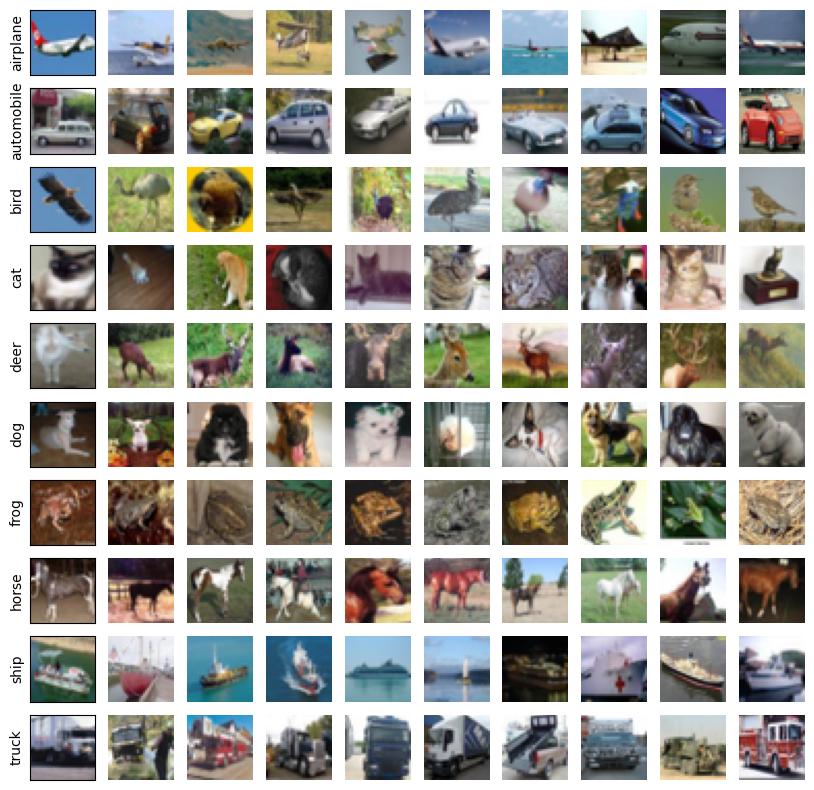

In [5]:
# Visualization
num_per_class = 10
fig, axes = plt.subplots(nrows=num_per_class, ncols=len(cifar10_classes), figsize = (10,10))
for idx, cls_name in enumerate(cifar10_classes):
    lbl_idxs = np.where(labels == idx)[0]
    for row in range(num_per_class):
        disp_idx = random.choice(lbl_idxs)
        img = images[disp_idx]
        axes[idx][row].imshow(img)
        if row == 0:
            axes[idx][row].set_ylabel(cls_name)
            axes[idx][row].set_xticks([])
            axes[idx][row].set_yticks([])
            continue
        axes[idx][row].axis('off')

In [6]:
data_idxs = []
for idx, cls_name in enumerate(cifar10_classes):
    lbl_idxs = np.where(labels == idx)[0]
    idxs = np.random.choice(lbl_idxs, max_n, replace=False)
    data_idxs.extend(idxs)

In [7]:
# DataLoader
class Cifar10(Dataset):
    def __init__(self, images, labels, idxs, transform = None):
        self.images = images[idxs]
        self.labels = labels[idxs]
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        lbl = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, lbl
    
train_dataset = Cifar10(images, labels, data_idxs, train_transforms)
trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, 
                         num_workers=16, pin_memory=True)